# DMA Fall '23


In [ ]:
NAME = "Jeonghyun Lee"
COLLABORATORS = ""

---

# Lab 3: Decision Trees

**Please read the following instructions very carefully**

## Working on the assignment / FAQs
- **Always use the seed/random_state as *42* wherever applicable** (This is to ensure repeatability in answers, across students and coding environments)
- Questions can be either autograded and manually graded.
- The type of question and the points they carry are indicated in each question cell
- An autograded question has 3 cells
     - **Question cell** : Read only cell containing the question
     - **Code Cell** : This is where you write the code
     - **Grading cell** : This is where the grading occurs, and **you are required not to edit this cell**
- Manually graded questions only have the question and code cells. **All manually graded questions are explicitly stated**
- To avoid any ambiguity, each question also specifies what *value* must be set. Note that these are dummy values and not the answers
- If an autograded question has multiple answers (due to differences in handling NaNs, zeros etc.), all answers will be considered.
- Most assignments have bonus questions for extra credit, do try them out!
- You can delete the `raise NotImplementedError()` for all questions.
- **Submitting the assignment** : Download the '.ipynb' and '.pdf' files from Colab and upload them to bcourses. Do not delete any outputs from cells before submitting.
- That's about it. Happy coding!


## About the dataset
This assignment uses a dataset obtained from the JSE Data Archive that contains biological and self-reported activity traits of a sample of college students at a single university uploaded in 2013. The study associated with these data focused on exploring if a correspondence exists between eye color and other traits. You will be using gender as the target/label in this lab.

FEATURE DESCRIPTIONS:
- Color (Blue, Brown, Green, Hazel, Other)
- Age (in years)
- YearinSchool (First, Second, Third, Fourth, Other)
- Height (in inches)
- Miles (distance from home town of student to Ames, IA)
- Brothers (number of brothers)
- Sisters (number of sisters)
- CompTime (number of hours spent on computer per week)
- Exercise (whether the student exercises Yes or No)
- ExerTime (number of hours spent exercising per week)
- MusicCDs (number of music CDs student owns)
- PlayGames (number of hours spent playing games per week)
- WatchTV (number of hours spent watching TV per week)

Background Information on the dataset: http://jse.amstat.org/v21n2/froelich/eyecolorgender.txt

In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt


!wget -nc http://askoski.berkeley.edu/~zp/eye_color.csv
!ls
df = pd.read_csv('eye_color.csv')
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', subset=None, inplace=False)
df = df.reset_index(drop=True)

df.head()

--2023-09-20 07:26:55--  http://askoski.berkeley.edu/~zp/eye_color.csv
Resolving askoski.berkeley.edu (askoski.berkeley.edu)... 169.229.192.179
Connecting to askoski.berkeley.edu (askoski.berkeley.edu)|169.229.192.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101507 (99K) [text/csv]
Saving to: ‘eye_color.csv’

eye_color.csv       100%[===================>]  99.13K   460KB/s    in 0.2s    

2023-09-20 07:26:56 (460 KB/s) - ‘eye_color.csv’ saved [101507/101507]

eye_color.csv  sample_data


,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


---
**Question 1 (0.5 points, autograded)**: How many more females are in the dataset compared to males?

In [ ]:
num_males = df[df['gender'] == 'male'].shape[0]
num_females = df[df['gender'] == 'female'].shape[0]

#raise NotImplementedError()

In [ ]:
# The value set in the variables must be integers
female_diff = num_females - num_males

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(female_diff)

168


---
**Question 2 (0.5 points, autograded)**: What is the Gini Index of this dataset, using males and females as the target classes?

In [ ]:
total_sample = num_males + num_females
#raise NotImplementedError()

In [ ]:
# The value set in the variable must be float
gini_index = 1 - ((num_males / total_sample) ** 2 + (num_females / total_sample) ** 2)

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(gini_index)

0.4964292799047807


---
## Best Split of a numeric feature
**Question 3 (1.5 points, autograded)**: What is the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)

Recall that, to calculate the best split of this numeric field, you'll need to order your data by **unique** heights, then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to **minimize** the Gini Index).

In [ ]:
# YOUR CODE HERE
sorted_df = df.sort_values('height')
sorted_height = sorted_df['height'].unique()

midpoints = [(sorted_height[i] + sorted_height[i+1]) / 2 for i in range(len(sorted_height) - 1)]

# Function to compute Gini Index
def compute_gini(left, right):
    total = len(left) + len(right)

    m_left = sum(left['gender'] == 'male') / len(left)
    f_left = sum(left['gender'] == 'female') / len(left)
    m_right = sum(right['gender'] == 'male') / len(right)
    f_right = sum(right['gender'] == 'female') / len(right)

    gini_left = 1 - (m_left**2 + f_left**2)
    gini_right = 1 - (m_right**2 + f_right**2)

    weighted_gini = (len(left) / total) * gini_left + (len(right) / total) * gini_right
    return weighted_gini
#raise NotImplementedError()

In [ ]:
#The value set in the variable must be float
best_gini = float('inf')
best_split_point = None

for i in midpoints:
    left = sorted_df[sorted_df['height'] <= i]
    right = sorted_df[sorted_df['height'] > i]

    gini = compute_gini(left, right)

    if gini < best_gini:
        best_gini = gini
        best_split_point = i

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(best_split_point)

68.5


---
**Question 4 (0.5 points, autograded)**: What is the Gini index of the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)


In [ ]:
# YOUR CODE HERE

sorted_df = df.sort_values(by='height')

# Get the unique heights
sorted_height = sorted_df['height'].unique()

# Calculate midpoints
midpoints = [(sorted_height[i] + sorted_height[i+1]) / 2 for i in range(len(sorted_height) - 1)]

# Function to compute Gini Index
def compute_gini(left, right):
    total = len(left) + len(right)
    m_left = sum(left['gender'] == 'male') / len(left)
    f_left = sum(left['gender'] == 'female') / len(left)
    m_right = sum(right['gender'] == 'male') / len(right)
    f_right = sum(right['gender'] == 'female') / len(right)

    gini_left = 1 - (m_left**2 + f_left**2)
    gini_right = 1 - (m_right**2 + f_right**2)

    weighted_gini = (len(left) / total) * gini_left + (len(right) / total) * gini_right
    return weighted_gini

# raise NotImplementedError()

In [ ]:
# The value set in the variable must be float

best_gini = float('inf')
best_split_point = None

for i in midpoints:
    left = sorted_df[sorted_df['height'] <= i]
    right = sorted_df[sorted_df['height'] > i]

    gini = compute_gini(left, right)

    if gini < best_gini:
        best_gini = gini
        best_split_point = i

gini_of_best_split_point = best_gini

# YOUR CODE HERE
# raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(gini_of_best_split_point)

0.2655288120702919


---
**Question 5 (0.5 points, autograded)**: How much does this partitioning reduce the Gini Index over the Gini index of the overall dataset?

In [ ]:
# YOUR CODE HERE
gini_diff = gini_index - gini_of_best_split_point
#raise NotImplementedError()

In [ ]:
# The value set in the variable must be float
gini_difference = gini_diff
# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(gini_difference)

0.2309004678344888


---
**Question 6 (0.5 points, autograded)**: How many 'female' and 'male' rows are shorter than the best height split point?

In [ ]:
# YOUR CODE HERE
split_df = df[df['height'] <= best_split_point]

#raise NotImplementedError()

In [ ]:
# The value set in the variable must be integer
female_rows_below = split_df[split_df['gender'] == 'female'].shape[0]
male_rows_below = split_df[split_df['gender'] == 'male'].shape[0]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(female_rows_below, male_rows_below)

905 142


---
**Question 7 (0.5 points, autograded)**: How many 'female' and 'male' rows are taller than the best height split point?

In [ ]:
# YOUR CODE HERE
split_df = df[df['height'] > best_split_point]
#raise NotImplementedError()

In [ ]:
#The value set in the variable must be integer
female_rows_above = split_df[split_df['gender'] == 'female'].shape[0]
male_rows_above = split_df[split_df['gender'] == 'male'].shape[0]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(female_rows_above, male_rows_above)

173 768


---
## Best Split of a Categorial Variable

**Question 8 (0.5 points, autograded)**: How many possible splits are there of the eyecolor feature? (Assuming binary split). (Hint: Powersets from tutorial 3).

Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list.

(Tip: Many students have had trouble with this question in the past, and we highly recommend taking a look at tutorial 3 for guidance: https://colab.research.google.com/drive/13m3KZH1Y5EHB8Wm5_8PIeUL-jLFM0wu9?usp=sharing


In [ ]:
# YOUR CODE HERE
eyecolor = df['eyecolor'].unique()
eyecolor
#raise NotImplementedError()

array(['hazel', 'brown', 'green', 'blue', 'other'], dtype=object)

In [ ]:
# The value set in the variable must be integer
num_of_splits = sum(1 for k in range(1, len(eyecolor)) for _ in combinations(eyecolor, k))

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(num_of_splits)

30


---
**Question 9 (1 points, autograded)**: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?

In [ ]:
# YOUR CODE
eyecolor = df['eyecolor'].unique().tolist()

def compute_gini(group1, group2):
    m_group1 = sum(group1['gender'] == 'male') / len(group1)
    f_group1 = sum(group1['gender'] == 'female') / len(group1)
    m_group2 = sum(group2['gender'] == 'male') / len(group2)
    f_group2 = sum(group2['gender'] == 'female') / len(group2)

    total = len(group1) + len(group2)


    gini_group1 = 1 - (m_group1**2 + f_group1**2)
    gini_group2 = 1 - (m_group2**2 + f_group2**2)

    weighted_gini = (len(group1) / total) * gini_group1 + (len(group2) / total) * gini_group2
    return weighted_gini
#raise NotImplementedError()

In [ ]:

best_gini = float('inf')
colour_group_1 = []
colour_group_2 = []

for k in range(1, len(eyecolor)):
    for subset in combinations(eyecolor, k):
        group1 = df[df['eyecolor'].isin(subset)]
        group2 = df[~df['eyecolor'].isin(subset)]

        gini = compute_gini(group1, group2)

        if gini < best_gini:
            best_gini = gini
            colour_group_1 = list(subset)
            colour_group_2 = [color for color in eyecolor if color not in subset]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(colour_group_1, colour_group_2)

['green'] ['hazel', 'brown', 'blue', 'other']


---
**Question 10 (0.5 points, autograded)**: What is the Gini Index of this best split?

In [ ]:
# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# The value set in the variable must be float
gini_of_best_split_group = best_gini

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(gini_of_best_split_group)

0.4930915729509777


---
**Question 11 (0.5 points, autograded)**: How much does this partitioning decrease the Gini Index over the Gini index of the overall dataset?

In [ ]:
# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
#The value set in the variable must be float
gini_difference_2 = gini_index - gini_of_best_split_group

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(gini_difference_2)

0.003337706953802977


---
**Question 12 (1 points, autograded)** : How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?

In [ ]:
# YOUR CODE HERE
partition1 = df[df['eyecolor'].isin(colour_group_1)]
partition2 = df[df['eyecolor'].isin(colour_group_2)]

#raise NotImplementedError()

In [ ]:
# The value set in the variable must be integer, order doesn't matter
partition1_male = partition1[partition1['gender'] == 'female'].shape[0]
partition1_female = partition1[partition1['gender'] == 'male'].shape[0]
partition2_male = partition2[partition2['gender'] == 'female'].shape[0]
partition2_female = partition2[partition2['gender'] == 'male'].shape[0]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(partition1_male, partition1_female, partition2_male, partition2_female)

190 107 888 803


---
## Training a decision tree
**Question 13 (1 points, autograded)**: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (not including the root node). What is the accuracy of this classifier on the training data)?

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: https://nbviewer.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().

In [ ]:
# YOUR CODE HERE

from sklearn.metrics import accuracy_score


features_df = df.drop('gender', axis=1)
dict_features = features_df.to_dict('records')
vec = DictVectorizer()
X = vec.fit_transform(dict_features).toarray()


le = preprocessing.LabelEncoder()
y = le.fit_transform(df['gender'])


clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)


y_pred = clf.predict(X)


#raise NotImplementedError()

In [ ]:
# The value set in the variable must be float
accuracy = accuracy_score(y, y_pred) * 100

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# This is an autograded cell, do not edit
print(accuracy)

86.46881287726357


---
**Question 14 (1 points, manually graded)**: Using the following code snippet, visualize your decision tree. In your write-up, **write down the interpretation of the rule at each node** which is used to perform the splitting.

We provide **two options** to visualize decision trees. The first option uses `tree.plot_tree` and the other uses an external tool called `GraphViz`. You can **use either of the two options**.  `tree.plot_tree` is the **recommended and easier option** as it is a built-in function in `sklearn` and doesn't require any additional setup.

Uncomment the code, **fill in the clf (classifier) and `feature_names` arguments**. Executing the code will display the tree visualization in the output cell.

Note for users who want to install graphviz on their local machines (**you don't need to do install graphviz if you're running the notebook Colab**, which is the class' recommended way of doing assignments):



> In order to install graphviz, you may need to download the tool from [this website](https://graphviz.gitlab.io), and then pip3/conda install the python libraries you do not have. Mac users can use ```brew install graphviz``` instead of following the link, and linux users can do the same using their favourite package manager (for example, Ubuntu users can use ```sudo apt-get install graphviz```, followed by the necessary pip3/conda installations.




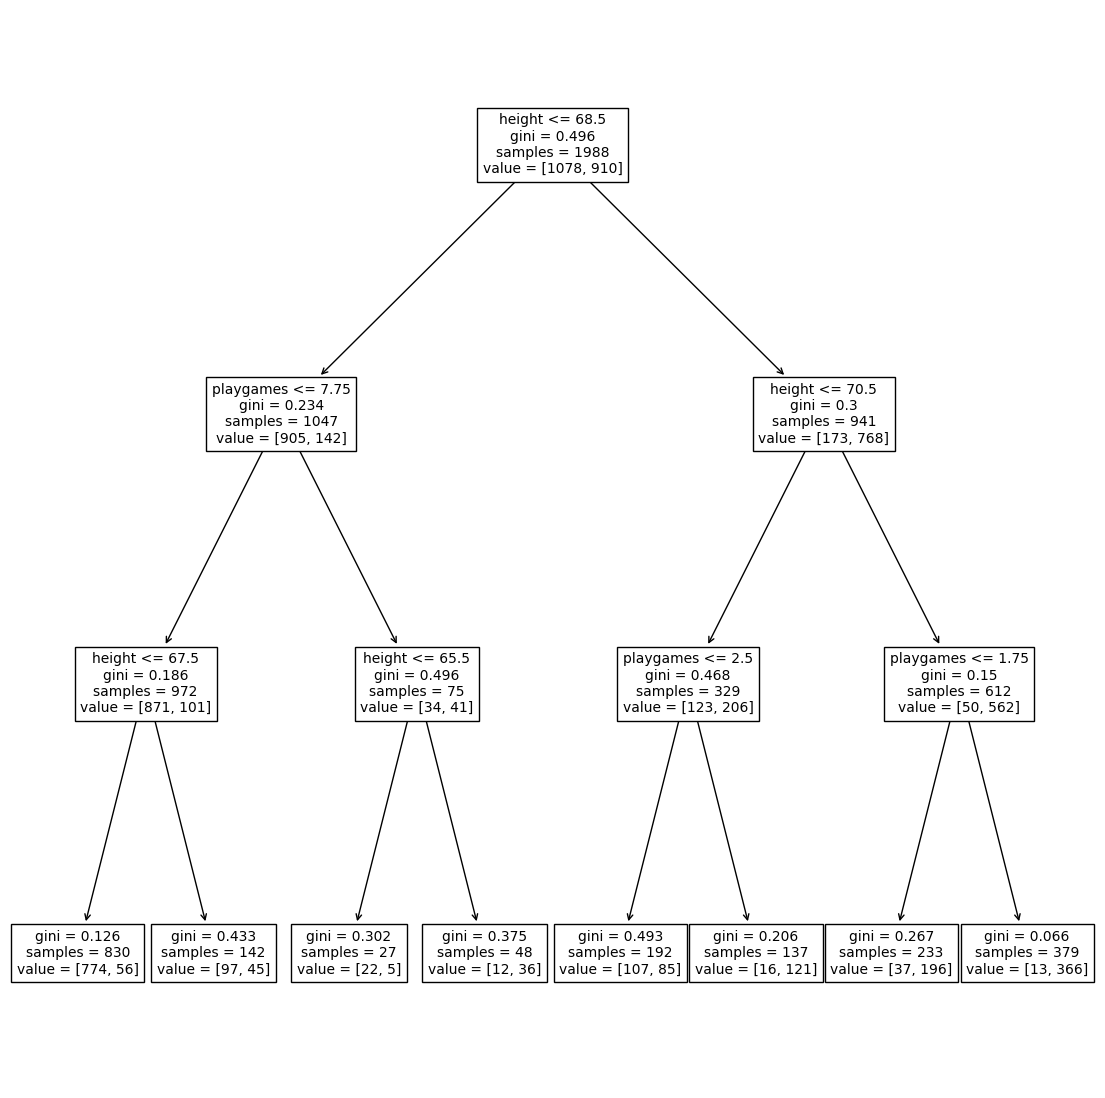

In [ ]:
# Option 1 (Recommended Option) - Using `tree.plot_tree`

# clf = your classifier
fig, ax = plt.subplots(figsize=(14, 14))
tree.plot_tree(clf, fontsize=10, feature_names=vec.get_feature_names_out());
plt.show()

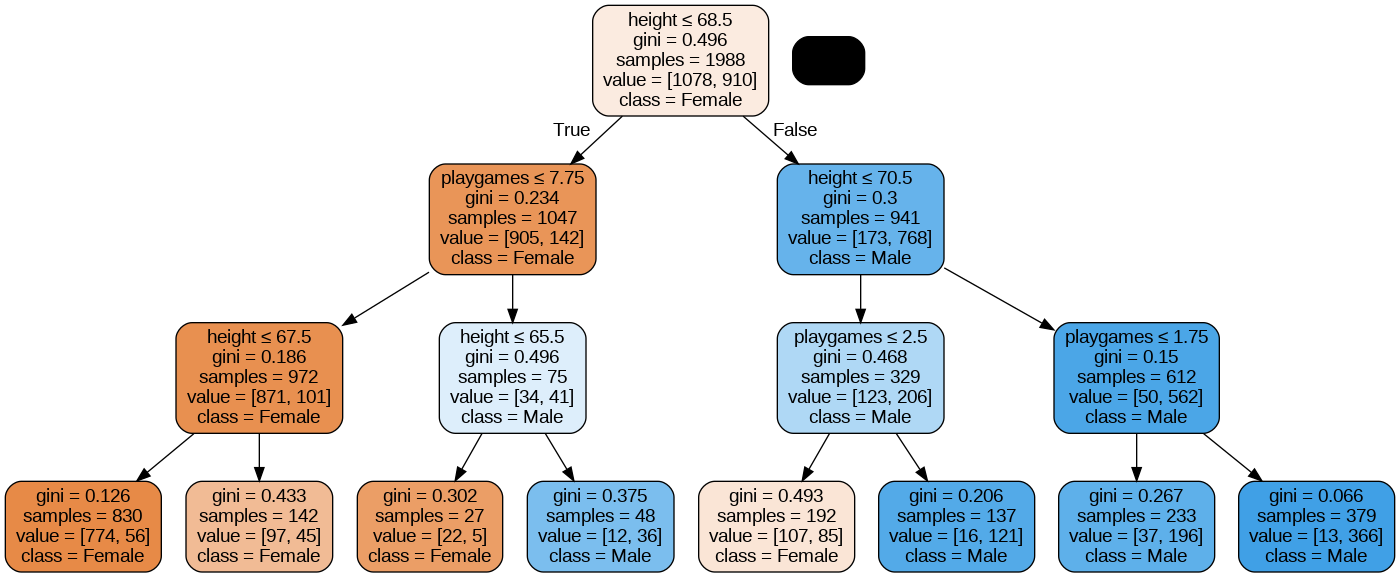

In [ ]:
# Option 2 - Using GraphViz. Visualization is prettier, but additional setup may be required if running on your local machine (although no setup required on Colab)

from IPython.display import Image
import pydotplus
import pydot
from six import StringIO

clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)
dotfile = StringIO()
tree.export_graphviz(clf, out_file=dotfile,
                      feature_names=vec.get_feature_names_out(),
                          class_names=['Female', 'Male'],
                          filled=True, rounded=True,
                          special_characters=True)
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())


# Ignore the cell below, but do not delete it. It is used to grade the image output of this cell.

In [ ]:
# YOUR CODE HERE
#raise NotImplementedError()

---
## Bonus Question (2 points, auto graded)
For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node)


In [ ]:
n_node_samples = clf.tree_.n_node_samples
value = clf.tree_.value
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right

# Identify leaf nodes
is_leaves = np.zeros(shape=n_node_samples.shape, dtype=bool)
stack = [(0, -1)]  # start with the root node id (0) and its parent depth (-1)
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

# Compute the percentage of 'female' rows for each leaf node
ratios = []
for node_id in np.where(is_leaves)[0]:
    female_count = value[node_id][0][0]  # Assuming 'Female' is the first class
    total_count = n_node_samples[node_id]
    ratio = (female_count / total_count) * 100
    ratios.append(ratio)


In [ ]:
# This is an autograded cell, do not edit
print(ratios)

[93.25301204819277, 68.30985915492957, 81.48148148148148, 25.0, 55.729166666666664, 11.678832116788321, 15.879828326180256, 3.430079155672823]


*ⓒ Prof. Zachary Pardos, 2022*